## Ideas

* MDS the Kmeans on speech graph
* Try other maninfold algos
* Try the clustering algo from ML last semester

http://scikit-learn.org/stable/modules/manifold.html

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#example-text-document-clustering-py

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

======

Ideas for 38 clusters

* Calculate noise probability in speech graph
* Spectral clusting on inverse, the break down clusters
* Add links to speech graph, use Laplacian, then break down clusters by projecting to debate-words subspace
* LDA using only the 25000 words
* Instead of breaking down clusters by projecting, use LDA on the smaller clusters

## Imports

In [1]:
import collections
import gensim
import heapq
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from matplotlib import offsetbox
from scipy.sparse import csr_matrix
from sklearn import cluster, datasets, decomposition, ensemble, lda, manifold, random_projection
from sklearn.decomposition import TruncatedSVD

%matplotlib inline


To start you off, you are told that points (rows, where the first row is number 0) 2, 13, 18, 24 are examples of speeches that belong to category “Against" (=label 0) and speeches 1, 3, 27, 177 are examples of speeches that belong to the “For”(=label 1) category

In [60]:
LABELS_AGAINST = set([2, 13, 18, 24])
LABELS_FOR = set([1, 3, 27, 177])

ORIG_LABELS = set([2, 13, 18, 24, 1, 3, 27, 177])

In [3]:
# Skip parts that take a long time.
SKIP_LONG_PARTS = True

# Create a dense representation of the data.
CREATE_DENSE_ARRAY = False

NUM_SPEECHES = 2740

NUM_DEBATES = 38

In [115]:
def write_evaluation(tuples, filename):
    f = open(filename, 'w+')
    f.write('Id,Prediction\n')
    for t in tuples:
        f.write(str(t[0]) + ',' + str(t[1]) + '\n')

## Import data

In [4]:
def load_sparse_data(filename, num_lines):
    """
    Function to load sparse data.
    """
    inverted_index = collections.defaultdict(set)
    
    sparse_indptr = [0]
    sparse_indices = []
    sparse_data = []
    vocabulary = {}

    print 'Reading data.'
    for line_num, line in enumerate(open(filename)):
        new_row = [(idx,float(prob)) for idx, prob in enumerate(line.strip().split(',')) if float(prob) > 0.0]
        for i,p in new_row:
            sparse_indices.append(i)
            sparse_data.append(p)
            inverted_index[i].add(line_num)
        sparse_indptr.append(len(sparse_indices))

        if line_num % 150 == 0:
            print 100.0 * line_num / num_lines, '%'
    print 100.0 * line_num / num_lines, '%'
    print 'Done reading data.'

    sparse_matrix = csr_matrix((sparse_data, sparse_indices, sparse_indptr), dtype=float)
    return sparse_matrix, inverted_index

In [47]:
def sparse_where(sparse_matrix, num):
    """
    np.where() for a sparse matrix. Returns a set of indices.
    """
    return set(np.where(sparse_matrix[num,:].toarray())[1].tolist())

### Load Speech Vectors

In [6]:
sparse_data, inverted_index = load_sparse_data('speech_vectors.csv', NUM_SPEECHES)
print sparse_data.shape

Reading data.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %
Done reading data.
(2740, 50000)


#### Load Speech Graph

In [7]:
speech_graph, inverted_graph = load_sparse_data('speech_graph.csv', NUM_SPEECHES)
print speech_graph.shape

Reading data.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %
Done reading data.
(2740, 2740)


In [113]:
"""
Assert that the sparse matrix is in the correct format.
"""
for line_num, line in enumerate(open('speech_vectors.csv')):
    new_row = set([idx for idx, freq in enumerate(line.strip().split(',')) if float(freq) > 0.0])
    assert len(new_row.difference(sparse_where(sparse_data, line_num))) == 0
    
    if line_num % 200 == 0:
        print 100.0 * line_num / NUM_SPEECHES, '%'
print 100.0 * line_num / NUM_SPEECHES, '%'
print 'Done'

0.0 %
7.29927007299 %
14.598540146 %
21.897810219 %
29.197080292 %
36.496350365 %
43.795620438 %
51.0948905109 %
58.3941605839 %
65.6934306569 %
72.9927007299 %
80.2919708029 %
87.5912408759 %
94.8905109489 %
99.9635036496 %


In [16]:
print len(dense_data), len(dense_data[0])

# In case you need a dense data representation.
if CREATE_DENSE_ARRAY:
    dense_data = sparse_data.toarray()
    print dense_data.shape
    for i in range(dense_data.shape[0]):
        sparse_row_set = set(np.where(sparse_data[i,:].toarray())[1].tolist())
        dense_row_set = set(np.where(dense_data[i,:])[0].tolist())
        
        assert sparse_row_set == dense_row_set

2740 557
(2740L,)
(array([  0,   0,   1, ..., 555, 556, 556], dtype=int64), array([0, 1, 0, ..., 1, 0, 1], dtype=int64))


IndexError: too many indices for array

#### A look at the inverted index.

In [4]:
word_dfs = [len(inverted_index[k]) for k in inverted_index]

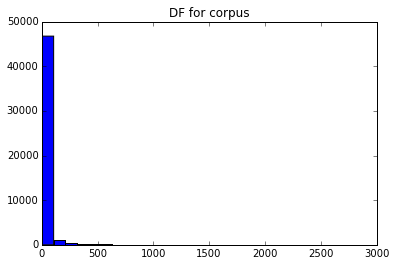

In [61]:
plt.hist(word_dfs, bins=25)
plt.title('DF for corpus')

12017


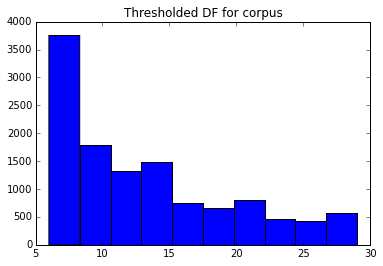

In [12]:
threshed_dfs = [df for df in word_dfs if 5 < df < 30]
print len(threshed_dfs)
plt.hist(threshed_dfs)
plt.title('Thresholded DF for corpus')

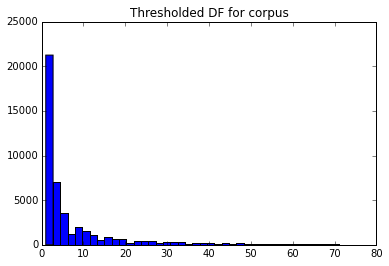

In [65]:
threshed_dfs = [df for df in word_dfs if df < 72]
plt.hist(threshed_dfs, bins=40)
plt.title('Thresholded DF for corpus')

16803
3 3 4


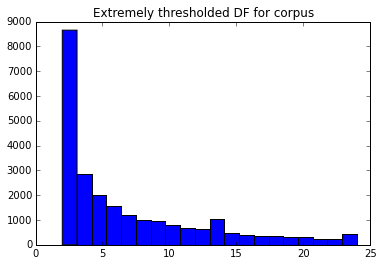

In [68]:
print word_dfs.count(1)
print word_dfs.count(285), word_dfs.count(296), word_dfs.count(329)
extreme_threshed_dfs = [df for df in word_dfs if 1 < df < 25]
plt.hist(extreme_threshed_dfs, bins=20)
plt.title('Extremely thresholded DF for corpus')

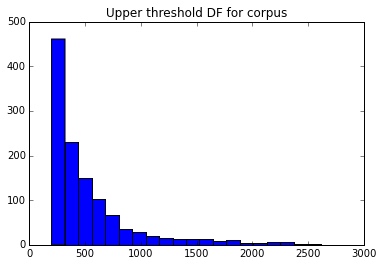

In [62]:
upper_dfs = [df for df in word_dfs if df > 200]
plt.hist(upper_dfs, bins=20)
plt.title('Upper threshold DF for corpus')

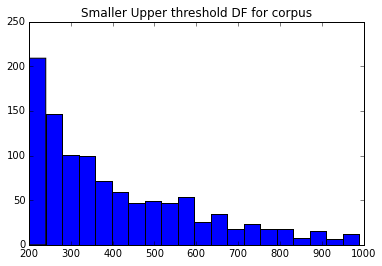

In [63]:
smaller_upper_dfs = [df for df in word_dfs if 1000 > df > 200]
plt.hist(smaller_upper_dfs, bins=20)
plt.title('Smaller Upper threshold DF for corpus')

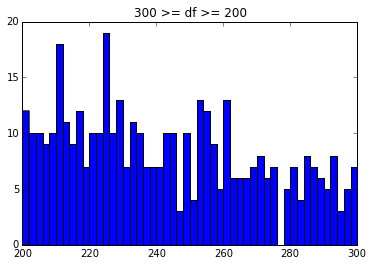

In [71]:
plt.hist([df for df in word_dfs if 300 >= df >= 200], bins=50)
plt.title('300 >= df >= 200')

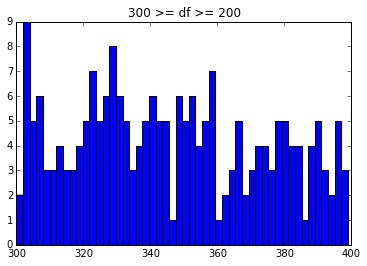

In [72]:
plt.hist([df for df in word_dfs if 400 >= df >= 300], bins=50)
plt.title('400 >= df >= 300')

## Are there two docs that share a lot of words?

In [6]:
two_docs_counter = collections.defaultdict(int)

for k in inverted_index:
    v = inverted_index[k]
    if len(v) == 2:
        two_docs_counter[str(sorted(v))] += 1
        
print len(two_docs_counter)

2261


[38, 18, 18, 13, 12, 11, 8, 8, 8, 8]


(array([  1.37900000e+03,   1.70000000e+01,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  2. ,   5.6,   9.2,  12.8,  16.4,  20. ,  23.6,  27.2,  30.8,
         34.4,  38. ]),
 <a list of 10 Patch objects>)

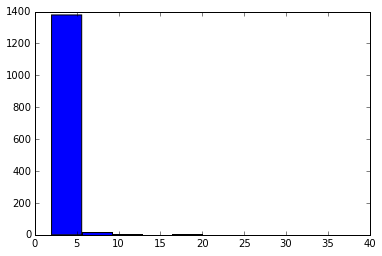

In [7]:
two_docs_counter_values = two_docs_counter.values()
two_docs_counter_values = [v for v in two_docs_counter_values if v > 1]
two_docs_counter_values.sort(reverse=True)

print two_docs_counter_values[0:10]

plt.hist(two_docs_counter_values)

In [10]:
counter = 0
for k in two_docs_counter:
    if two_docs_counter[k] > 1:
        counter += 1
        print k, two_docs_counter[k]
        
print counter

[230, 561] 2
[646, 668] 7
[145, 249] 3
[227, 228] 2
[1006, 2254] 3
[827, 870] 4
[1959, 2111] 2
[270, 804] 3
[510, 2675] 3
[272, 590] 4
[1618, 2441] 2
[855, 1665] 4
[20, 1360] 4
[359, 1645] 4
[2134, 2276] 2
[236, 808] 2
[1131, 2158] 2
[122, 1930] 3
[1617, 2270] 3
[576, 2576] 2
[233, 2723] 2
[1549, 2333] 3
[1654, 1860] 2
[1724, 2065] 8
[1487, 1762] 2
[1097, 1772] 2
[668, 2425] 3
[653, 1076] 2
[1839, 2517] 2
[20, 1956] 4
[458, 1392] 3
[269, 2453] 6
[20, 1735] 3
[387, 941] 3
[1871, 2060] 4
[1173, 1818] 3
[429, 2388] 2
[2383, 2701] 3
[70, 2235] 2
[897, 1647] 2
[646, 1537] 7
[20, 730] 2
[464, 1169] 3
[1312, 2056] 2
[940, 2282] 2
[951, 2403] 2
[862, 1577] 2
[351, 1024] 3
[668, 1864] 2
[1482, 2349] 4
[668, 1794] 2
[204, 2217] 2
[3, 259] 2
[1916, 2707] 2
[1510, 1617] 3
[233, 2515] 3
[339, 1905] 2
[90, 967] 2
[1935, 2681] 2
[650, 963] 3
[1857, 2317] 2
[1410, 1606] 2
[2308, 2659] 2
[212, 972] 2
[161, 2425] 2
[807, 1419] 2
[1622, 2428] 2
[2109, 2556] 2
[1392, 1515] 3
[716, 1836] 2
[145, 238] 4
[10

In [6]:
def jaccard(a,b):
    if len(a.union(b)) == 0: return 0
    
    numerator = a.intersection(b)
    denominator = a.union(b)
    
    numerator = sum([1.0 / len(inverted_index[i]) for i in numerator])
    denominator = sum([1.0 / len(inverted_index[i]) for i in denominator])
    return 1.0 * numerator / denominator

In [12]:
first_index = 1637
second_index = 2276

a = set(np.where(sparse_data[first_index,:].toarray())[1].tolist())
b = set(np.where(sparse_data[second_index,:].toarray())[1].tolist())

c = set(np.where(sparse_data[0,:].toarray())[1].tolist())

print jaccard(a,b)
print jaccard(a,c)
print jaccard(c,b)

max_jaccard = 0.0
closest_neighbor = -1
for row in range(NUM_SPEECHES):
    if row == first_index:
        continue
    j_sim = jaccard(a, set(np.where(sparse_data[row,:].toarray())[1].tolist()))
    
    if j_sim > max_jaccard:
        max_jaccard = j_sim
        closest_neighbor = row
        
print closest_neighbor, max_jaccard

0.105336925479
0.00442184886533
0.00461829250427
2276 0.105336925479


#### Heapq test

In [46]:
h = []
heapq.heappush(h, (5, 'write code'))
heapq.heappush(h, (7, 'release product'))
heapq.heappush(h, (1, 'write spec'))
heapq.heappush(h, (3, 'create tests'))
while len(h) > 0:
    print heapq.heappop(h)

(1, 'write spec')
(3, 'create tests')
(5, 'write code')
(7, 'release product')


In [48]:
a = [1,2,3,4,5]
b = a.pop(2)
print b
print a

s = set()
s.add(1)
s.add(2)
s.add(3)
print s
s.remove(3)
print s

b = a
print a,b
b.pop()
print a,b

a = [[1,2], [3,4]]
a[1].append(2)
print a

print np.isclose(0.0, 1.0/25000)
print 0.0 != 1.0/25000

3
[1, 2, 4, 5]
set([1, 2, 3])
set([1, 2])
[1, 2, 4, 5] [1, 2, 4, 5]
[1, 2, 4] [1, 2, 4]
[[1, 2], [3, 4, 2]]
False
True


#### Jaccard and heapq

In [41]:
print NUM_SPEECHES

print range(2, 5)

len(set(np.where(dense_data[1,:])[0].tolist()))

2740
[2, 3, 4]


750

In [7]:
if dense_data:
    threshold_columns = [col for col in inverted_index if 330 > len(inverted_index[col]) > 1]
    dense_data = dense_data[:,threshold_columns]

# For sparse matrix
row_sets = [set(np.where(sparse_data[i,:].toarray())[1].tolist()) for i in range(NUM_SPEECHES)]
# For dense matrix
#row_sets = [set(np.where(dense_data[i,:])[0].tolist()) for i in range(NUM_SPEECHES)]

jaccard_heap = []

print 'Creating jaccard_heap'
t0 = time()
for row1 in range(NUM_SPEECHES):
    if row1 % 75 == 0: print 100.0 * row1 / NUM_SPEECHES, '%'
    for row2 in range(row1+1, NUM_SPEECHES):
        heapq.heappush(jaccard_heap, (-jaccard(row_sets[row1], row_sets[row2]), (row1, row2)) )
print 'Time:', time() - t0
        
print 'Heap size:', len(jaccard_heap)
cluster_tracker = {}
unlabeled = set(range(NUM_SPEECHES))
print len(unlabeled)
clusters = []

print 'Calculating clusters.'
t0 = time()

iteration = 0

while len(unlabeled) + len(clusters) != NUM_DEBATES:
    next_tuple = heapq.heappop(jaccard_heap)
    row1 = next_tuple[1][0]
    row2 = next_tuple[1][1]
    
    # Both are unlabeled.
    if row1 in unlabeled and row2 in unlabeled:
        cluster_tracker[row1] = len(clusters)
        cluster_tracker[row2] = len(clusters)
        clusters.append( [row1, row2] )
        unlabeled.remove(row1)
        unlabeled.remove(row2)
    # row1 is not labeled
    elif row1 in unlabeled:
        row2_index = cluster_tracker[row2]
        clusters[row2_index].append(row1)
        cluster_tracker[row1] = row2_index
        unlabeled.remove(row1)
    # row2 is not labeled
    elif row2 in unlabeled:
        row1_index = cluster_tracker[row1]
        clusters[row1_index].append(row2)
        cluster_tracker[row2] = row1_index
        unlabeled.remove(row2)
    # Both are already labeled, but in different clustesr.
    elif cluster_tracker[row1] != cluster_tracker[row2]:
        row1_index = cluster_tracker[row1]
        old_row2_index = cluster_tracker[row2]
        # Merge row2's cluster into row1's cluster.
        row2_cluster = clusters[old_row2_index]
        clusters[row1_index].extend(row2_cluster)
        clusters.pop(old_row2_index)
        
        # Update indices > row2
        for index in cluster_tracker:
            if cluster_tracker[index] > old_row2_index:
                cluster_tracker[index] -= 1
        # Update row2's cluster indices.
        row1_index = cluster_tracker[row1]
        for index in row2_cluster:
            cluster_tracker[index] = row1_index
    # Else both are in the same cluster already.
    
    iteration += 1
    #if iteration % 1000 == 0: print iteration
                
print 'Time:', time() - t0

Creating jaccard_heap
0.0 %
2.73722627737 %
5.47445255474 %
8.21167883212 %
10.9489051095 %
13.6861313869 %
16.4233576642 %
19.1605839416 %
21.897810219 %
24.6350364964 %
27.3722627737 %
30.1094890511 %
32.8467153285 %
35.5839416058 %
38.3211678832 %
41.0583941606 %
43.795620438 %
46.5328467153 %
49.2700729927 %
52.0072992701 %
54.7445255474 %
57.4817518248 %
60.2189781022 %
62.9562043796 %
65.6934306569 %
68.4306569343 %
71.1678832117 %
73.9051094891 %
76.6423357664 %
79.3795620438 %
82.1167883212 %
84.8540145985 %
87.5912408759 %
90.3284671533 %
93.0656934307 %
95.802919708 %
98.5401459854 %
Time: 1850.82299995
Heap size: 3752430
2740
Calculating clusters.
Time: 1.30700016022


In [8]:
print 'Number of points in a labeled cluster', len(cluster_tracker)
print 'Number of unlabeled points', len(unlabeled)
print '# of clusters', len(cluster_tracker) + len(unlabeled)
print len(jaccard_heap)
print len(row_sets)
print '====='
cluster_lengths = [len(c) for c in clusters]
print cluster_lengths
print sum(cluster_lengths)
print '====='
#for c in clusters:
#    print c
    
all_points = []
for c in clusters:
    all_points.extend(c)
    
all_points.sort()
print '===='
print all_points[:20]

Number of points in a labeled cluster 2705
Number of unlabeled points 35
# of clusters 2740
3653845
2740
=====
[2, 2, 2701]
2705
=====
====
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


## Utility functions

In [21]:
def entropy(p):
    """
    Calculates the entropy of a discrete distribution using base e.
    http://en.wikipedia.org/wiki/Entropy_(information_theory)

    Arguments:
        p: A list representing a discrete distribution (sums to 1).

    Returns:
        The entropy of the distribution.
    """

    return -np.sum([x * np.log(x) for x in p if x != 0])

def jsd(p, q):
    """
    Calculates the Jensen-Shannon divergence between two discrete probability
    distributions. Assumes the distributions are equally weighted.
    http://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

    Arguments:
        p: A list representing discrete probability distribution (sums to 1).
        q: A list representing discrete probability distribution (sums to 1).

    Returns:
        A float representing the Jensen-Shannon divergence, using base e.
    """

    p = np.array(p)
    q = np.array(q)

    return entropy(0.5*p + 0.5*q) - 0.5 * (entropy(p) + entropy(q))

def jsd_tuple(tuple_p, tuple_q):
    """
    JSD for tuples.
    
    Assumes tuple[1] has the important data.
    """
    p_indices = {t[0]:t[1] for t in tuple_p}
    q_indices = {t[0]:t[1] for t in tuple_q}
    
    all_keys = set(p_indices.keys())
    for key in q_indices.keys():
        all_keys.add(key)
        
    all_keys = list(all_keys) # Preserve order?
    
    p = []
    q = []
    
    for key in all_keys:
        if key in p_indices:
            p.append(p_indices[key])
        else:
            p.append(0.0)
        
        if key in q_indices:
            q.append(q_indices[key])
        else:
            q.append(0.0)
            
    
    return jsd(p,q)

In [ ]:
def single_link(m, k, dist):
    '''
    Computes the single clink clustering for the given points:
    
    Arguments:
        m: A list of data points.
        k: The number of clusters.
        dist: The distance function.
    Returns:
        A 0-1 vector deliminating the clusters, in the same order as the input.
    '''
    clusters = [[i] for i in m]
    while len(clusters) > k:
        print len(clusters)
        # Find closest pair
        j1 = None
        j2 = None
        min_dist = float('inf')
        for c1 in clusters:
            for c2 in clusters:
                if c1 != c2:
                    for p in c1:
                        for q in c2:
                            d = dist(p,q)
                            
                            if d < min_dist:
                                j1 = c1
                                j2 = c2
                                min_dist = d

        # Update clustesr
        clusters.remove(j1)
        clusters.remove(j2)
        j1.extend(j2)
        clusters.append(j1)

    c = []
    for p in m:
        for i in range(k):
            if p in clusters[i]:
                c.append(i)
                break

    return c

### Single-link test

In [10]:
sl_cols = [col for col in inverted_index if 329 >= len(inverted_index[col]) >= 2]
print len(sl_cols)

sl_data = dense_data[:,sl_cols]
print 'sl_data.shape', sl_data.shape

# Sign() the thresholded data.
#signed_sl_data = np.sign(thresholded_data)

31473
sl_data.shape (2740L, 31473L)


In [ ]:
# sclusters = si

## Data Statistics

#### Investigate words that occur in a little/large amount of documents.

In [104]:
print 'Avg speeches per debate', NUM_SPEECHES / NUM_DEBATES

lower_word_percent_thresh = 9
print 'Est word thresh:', lower_word_percent_thresh

upper_word_percent_thresh = 31
print 'Est word thresh:', upper_word_percent_thresh

zero_one_split = 2740 * 0.52409
print 'Data split:' , zero_one_split

# Threshold the input data.
threshold_columns = [col for col in inverted_index if upper_word_percent_thresh > len(inverted_index[col]) > lower_word_percent_thresh]
thresholded_data = dense_data[:,threshold_columns]
print 'thresholded_data.shape', thresholded_data.shape

# Sign() the thresholded data.
signed_thresholded_data = np.sign(thresholded_data)

Avg speeches per debate 72
Est word thresh: 9
Est word thresh: 31
Data split: 1436.0066
thresholded_data.shape (2740L, 7481L)


Sorted subset of word_doc_occs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Num of words in only 1 doc: 16803
Num words with freq > est_word_thresh: 13091
Num words with freq < upper_word_percent_thresh: 46657


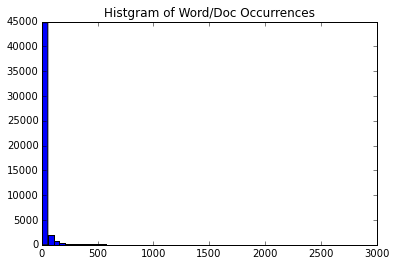

In [37]:
word_doc_occs = [len(inverted_index[w]) for w in inverted_index]
print 'Sorted subset of word_doc_occs:', sorted(word_doc_occs)[:10]
print 'Num of words in only 1 doc:', word_doc_occs.count(1)
print 'Num words with freq > est_word_thresh:', sum([1 for w in inverted_index if len(inverted_index[w]) > lower_word_percent_thresh])
print 'Num words with freq < upper_word_percent_thresh:', sum([1 for w in inverted_index if len(inverted_index[w]) < upper_word_percent_thresh])
plt.hist(word_doc_occs, bins=50)
plt.title('Histgram of Word/Doc Occurrences')

#### Investigate high entropy words.

[4.792846295791648, 4.7750591404233802, 4.7617200327941944, 4.7568878136881265, 4.7470202926506797, 4.7447988214215719, 4.7384972639503884, 4.7369740502534787, 4.7346353148575062, 4.732341498926365]


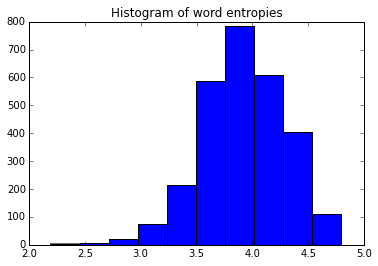

In [57]:
entropies = []
for col in inverted_index:
     if upper_word_percent_thresh > len(inverted_index[col]) > lower_word_percent_thresh:
            d = list(dense_data[:,col])
            d_sum = sum(d)
            d_norm = [i / d_sum for i in d]
            assert np.isclose(sum(d_norm),1.0), sum(d_norm)
            entropies.append(entropy(d_norm))
            
entropies.sort(reverse=True)
print entropies[:10]
            
plt.hist(entropies)
plt.title('Histogram of word entropies')

440
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[382.0, 424.0, 427.0, 438.0, 453.0, 460.0, 612.0, 661.0, 849.0, 916.0]
46.9211678832
65.093949432
(2740L, 7481L)


(array([  2.29200000e+03,   3.51000000e+02,   7.20000000e+01,
          1.40000000e+01,   6.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([   0. ,   91.6,  183.2,  274.8,  366.4,  458. ,  549.6,  641.2,
         732.8,  824.4,  916. ]),
 <a list of 10 Patch objects>)

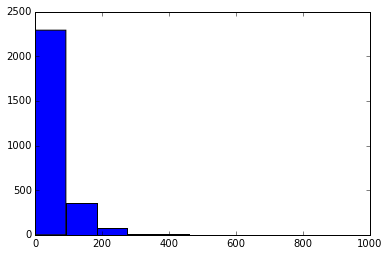

In [78]:
signed_thresholded_data_row_sums = []
for row in range(signed_thresholded_data.shape[0]):
    signed_thresholded_data_row_sums.append(sum(signed_thresholded_data[row,:]))
    
print sum(1 for i in signed_thresholded_data_row_sums if upper_word_percent_thresh > i > lower_word_percent_thresh)
signed_thresholded_data_row_sums.sort()
print signed_thresholded_data_row_sums[:10]
print signed_thresholded_data_row_sums[-10:]
print np.average(signed_thresholded_data_row_sums)
print np.std(signed_thresholded_data_row_sums)
print signed_thresholded_data.shape
plt.hist(signed_thresholded_data_row_sums)

## Single link

In [38]:
"""
def use_jsd_matrix(p, q):
    return jsd_matrix[jsd_matrix_map(str(p))][jsd_matrix_map(str(q))]

print 'Creating jsd_matrix_map.'
jsd_matrix_map = {str(d):i for i,d in enumerate(data)}

print 'Creating jsd_matrix.'
jsd_matrix = [range(NUM_DATA) for i in range(NUM_DATA)]
for i in range(NUM_DATA):
    print i
    for j in range(NUM_DATA):
        jsd_matrix[i][j] = jsd_tuple(data[i], data[j])

print 'Creating single_link_clusters'
single_link_clusters = single_link(data, 38, use_jsd_matrix)
"""

"\ndef use_jsd_matrix(p, q):\n    return jsd_matrix[jsd_matrix_map(str(p))][jsd_matrix_map(str(q))]\n\nprint 'Creating jsd_matrix_map.'\njsd_matrix_map = {str(d):i for i,d in enumerate(data)}\n\nprint 'Creating jsd_matrix.'\njsd_matrix = [range(NUM_DATA) for i in range(NUM_DATA)]\nfor i in range(NUM_DATA):\n    print i\n    for j in range(NUM_DATA):\n        jsd_matrix[i][j] = jsd_tuple(data[i], data[j])\n\nprint 'Creating single_link_clusters'\nsingle_link_clusters = single_link(data, 38, use_jsd_matrix)\n"

## Random Projection

In [42]:
sparse_transformer = random_projection.SparseRandomProjection()
data_new = sparse_transformer.fit_transform(sparse_data)
data_new.shape

(2740, 6784)

## T-SNE on Various Data Representations

#### T-SNE on Sparse Data Transformed using SVD

In [13]:
# Perform SVD first.
truncated_svd = TruncatedSVD(n_components=10, random_state=42)
truncated_svd_sparse_data = truncated_svd.fit_transform(sparse_data)
print 'Shape of truncated_svd_sparse_data:', truncated_svd_sparse_data.shape
print '% Variance explained by SVD:', truncated_svd.explained_variance_ratio_.sum()

 Shape of truncated_svd_sparse_data: (2740L, 10L)
% Variance explained by SVD: 0.454772124557


Shape of data_tsne: (2740L, 2L)


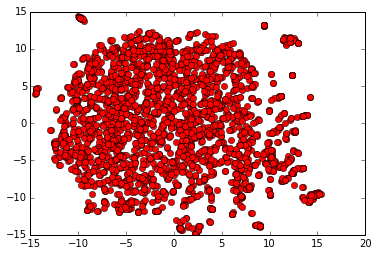

In [24]:
# Run TSNE
tsne_model_svd = manifoldT.SNE(n_components=2, random_state=0)
sparse_data_tsne = tsne_model_svd.fit_transform(truncated_svd_sparse_data)
print 'Shape of data_tsne:', sparse_data_tsne.shape

plt.plot(sparse_data_tsne[:,0], sparse_data_tsne[:,1], 'ro')

#### T-SNE on Thresholded, Dense Data Using PCA

In [58]:
# PCA on thresholded data.
pca_model = decomposition.PCA(n_components=50)
pca_thresholded_data = pca_model.fit_transform(thresholded_data)
print 'Shape of pca_data:', pca_data.shape
print '% Variance explained by SVD:', pca_model.explained_variance_ratio_.sum()

Shape of pca_data: (2740L, 50L)
% Variance explained by SVD: 0.684023179982


In [59]:
tsne_model_pca = manifold.TSNE(n_components=2, random_state=0)
thresholded_data_tsne = tsne_model_pca.fit_transform(pca_thresholded_data)
print 'Shape of data_tsne:', thresholded_data_tsne.shape

Shape of data_tsne: (2740L, 2L)


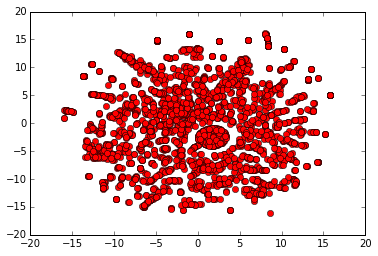

In [60]:
plt.plot(thresholded_data_tsne[:,0], thresholded_data_tsne[:,1], 'ro')

#### T-SNE on Thresholded, Dense Data Using PCA

In [ ]:
# PCA on signed thresholded data.
signed_thresholded_pca_model = decomposition.PCA(n_components=50)
pca_signed_thresholded_data = signed_thresholded_pca_model.fit_transform(signed_thresholded_data)
print 'Shape of pca_data:', pca_signed_thresholded_data.shape
print '% Variance explained by SVD:', signed_thresholded_pca_model.explained_variance_ratio_.sum()

tsne_model_pca_signed_thresholded = manifold.TSNE(n_components=2, random_state=0)
signed_thresholded_data_tsne = tsne_model_pca_signed_thresholded.fit_transform(pca_signed_thresholded_data)
print 'Shape of data_tsne:', signed_thresholded_data_tsne.shape
plt.plot(signed_thresholded_data_tsne[:,0], signed_thresholded_data_tsne[:,1], 'ro')

## K-Means on Thresholded Data

In [122]:
def hist_kmeans_labels(labels, var_name):

    counts = [labels.count(i) for i in range(NUM_DEBATES)]

    print 'Labels:', sorted(counts)
    print 'Avg:', np.average(counts)
    print 'Std dev:', np.std(counts)

    plt.hist(counts,  bins=38)
    plt.xlabel('Number of points in bins')
    plt.ylabel('# bins')
    plt.title('Histogram of ' + var_name)

In [90]:
def visualize_kmeans(data, estimator, title):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() + 1, data[:, 0].max() - 1
    y_min, y_max = data[:, 1].min() + 1, data[:, 1].max() - 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = estimator.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering using estimator ' + title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

#### Using the original thresholded data.

In [102]:
kmeans_clf = cluster.KMeans(n_clusters=NUM_DEBATES, n_init=10, max_iter=300)
kmeans_clf.fit(thresholded_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=38, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 9, 9, 10, 12, 13, 14, 16, 17, 19, 19, 21, 21, 26, 62, 2403]
Avg: 72.1052631579
Std dev: 383.357315079


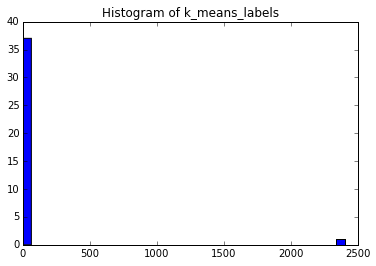

In [112]:
k_means_labels = list(kmeans_clf.labels_)

hist_kmeans_labels(k_means_labels, 'k_means_labels')

#### Using the signed thresholded data.

In [97]:
signed_kmeans_clf = cluster.KMeans(n_clusters=NUM_DEBATES, n_init=20, max_iter=300)
signed_kmeans_clf.fit(signed_thresholded_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=38, n_init=20,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 87, 143, 285, 519, 1670]
Avg: 72.1052631579
Std dev: 279.566373766


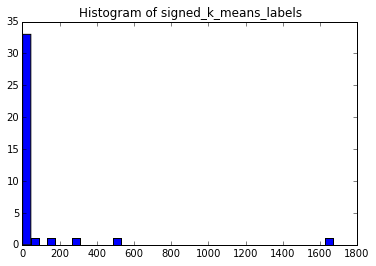

In [111]:
signed_k_means_labels = list(signed_kmeans_clf.labels_)

hist_kmeans_labels(signed_k_means_labels, 'signed_k_means_labels')

#### Trying to break down clusters

In [133]:
signed_thresholded_data_row_sums = []
for row in range(signed_thresholded_data.shape[0]):
    signed_thresholded_data_row_sums.append(sum(signed_thresholded_data[row,:]))
    
rows_to_keep = [i for i in signed_thresholded_data_row_sums if upper_word_percent_thresh > i > lower_word_percent_thresh]

pruned_signed_thresholded_data = thresholded_data[rows_to_keep, :]

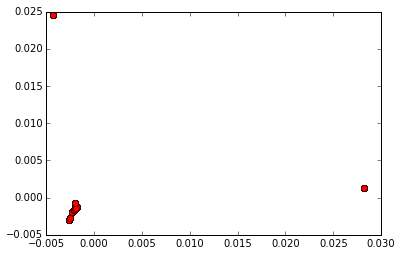

In [134]:
reduced_pruned_signed_thresholded_data = decomposition.PCA(n_components=25).fit_transform(pruned_signed_thresholded_data)

plt.plot(reduced_pruned_signed_thresholded_data[:,0], reduced_pruned_signed_thresholded_data[:,1], 'ro')

In [135]:
print reduced_pruned_signed_thresholded_data.shape

(440L, 25L)


Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 26, 31, 361]
Avg: 11.5789473684
Std dev: 57.88992803


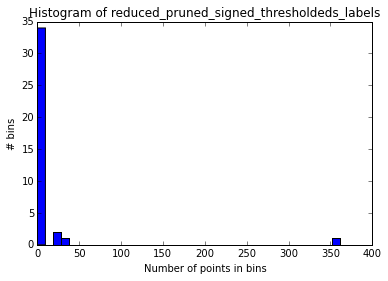

In [136]:
reduced_pruned_signed_thresholded_kmeans = cluster.KMeans(init='k-means++', n_clusters=4, n_init=10)
reduced_pruned_signed_thresholded_kmeans.fit(reduced_pruned_signed_thresholded_data)
reduced_pruned_signed_thresholdeds_labels = list(reduced_pruned_signed_thresholded_kmeans.labels_)

hist_kmeans_labels(reduced_pruned_signed_thresholdeds_labels, 'reduced_pruned_signed_thresholdeds_labels')

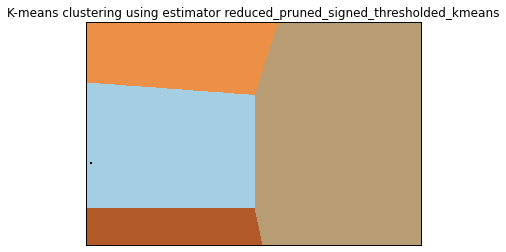

In [119]:
visualize_kmeans(reduced_pruned_signed_thresholded_data, reduced_pruned_signed_thresholded_kmeans, 'reduced_pruned_signed_thresholded_kmeans')

In [139]:
orig_rows = []
for i,a in zip(rows_to_keep,reduced_pruned_signed_thresholdeds_labels):
    if a == 0:
        orig_rows.append(i)

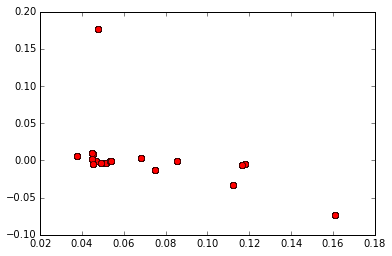

In [141]:
cluster_to_break_down = TruncatedSVD(n_components=10, random_state=42).fit_transform(dense_data[orig_rows,:])

plt.plot(cluster_to_break_down[:,0], cluster_to_break_down[:,1], 'ro')

#### Testing Using small threshold

In [ ]:
cols_to_keep = [k for
data_to_cluster = dense_data[

#### Using signed threshold PCA data.

In [114]:
#reduced_signed_thresholded_data = decomposition.PCA(n_components=2).fit_transform(signed_thresholded_data)
reduced_signed_thresholded_data = decomposition.PCA(n_components=2).fit_transform(thresholded_data)
reduced_signed_kmeans = cluster.KMeans(init='k-means++', n_clusters=NUM_DEBATES, n_init=10)
reduced_signed_kmeans.fit(reduced_signed_thresholded_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=38, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

Labels: [1, 1, 2, 3, 7, 8, 9, 10, 11, 14, 15, 16, 20, 21, 23, 25, 26, 26, 28, 35, 36, 37, 38, 48, 52, 59, 69, 69, 69, 82, 83, 84, 95, 129, 142, 153, 259, 935]
Avg: 72.1052631579
Std dev: 151.048056047


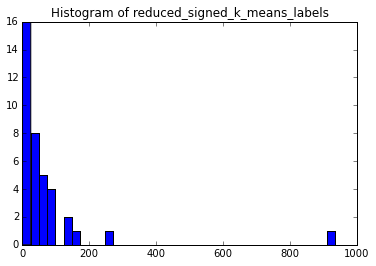

In [115]:
reduced_signed_k_means_labels = list(reduced_signed_kmeans.labels_)

hist_kmeans_labels(reduced_signed_k_means_labels, 'reduced_signed_k_means_labels')

Visualize the k-means output on the PCA data.

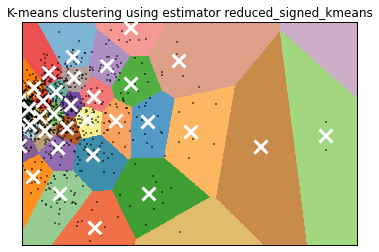

In [122]:
visualize_kmeans(reduced_signed_thresholded_data, reduced_signed_kmeans, 'reduced_signed_kmeans')

#### Kmeans using truncated SVD on original sparse matrix.

In [124]:
truncated_svd_for_kmeans = TruncatedSVD(n_components=2, random_state=42)
truncated_svd_kmeans_sparse_data = truncated_svd_for_kmeans.fit_transform(sparse_data)

In [125]:
truncated_sparse_kmeans = cluster.KMeans(init='k-means++', n_clusters=NUM_DEBATES, n_init=10)
truncated_sparse_kmeans.fit(truncated_svd_kmeans_sparse_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=38, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [128]:
print truncated_svd_kmeans_sparse_data.shape
truncated_sparse_kmeans_labels = list(truncated_sparse_kmeans.labels_)

hist_kmeans_labels(truncated_sparse_kmeans_labels, 'truncated_sparse_kmeans_labels')
visualize_kmeans(truncated_svd_kmeans_sparse_data, truncated_sparse_kmeans, 'truncated_sparse_kmeans')

(2740L, 2L)
Labels: [7, 9, 10, 11, 11, 12, 15, 21, 22, 26, 26, 26, 27, 28, 30, 31, 33, 38, 39, 40, 44, 56, 59, 64, 70, 72, 78, 84, 87, 97, 118, 158, 158, 162, 205, 239, 251, 276]
Avg: 72.1052631579
Std dev: 71.9143457885


ValueError: zero-size array to reduction operation minimum which has no identity

#### Upper Threshold

In [109]:
# Threshold the input data.

rows_to_keep = []
for row in range(signed_thresholded_data.shape[0]):
    if sum(signed_thresholded_data[row,:]) > 0.0:
        rows_to_keep.append(row)

# Sign() the thresholded data.
lower_thresholded_data = signed_thresholded_data[rows_to_keep, :]
print 'lower_thresholded_data.shape', lower_thresholded_data.shape

rows_to_keep_set = set(rows_to_keep)
rows_to_keep = []
for row in range(dense_data.shape[0]):
    if row not in rows_to_keep_set:
        rows_to_keep.append(row)
        
cols_to_keep = [i for i in range(NUM_SPEECHES) if i not in set(threshold_columns)]
lower_thresholded_inverse_data = dense_data[rows_to_keep, :]
lower_thresholded_inverse_data = lower_thresholded_data[:, cols_to_keep]
print 'lower_thresholded_inverse_data', lower_thresholded_inverse_data.shape

lower_thresholded_data.shape (2137L, 7481L)
lower_thresholded_inverse_data (2137L, 2680L)


####lower_thresholded_inverse_data

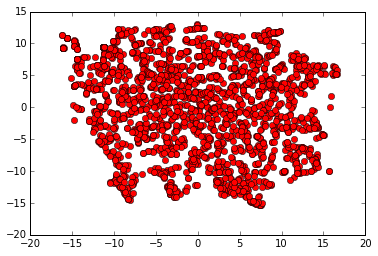

In [113]:
lower_thresholded_inverse_tsne_model = manifold.TSNE(n_components=2, random_state=0)
lower_thresholded_inverse_tsne_data = lower_thresholded_inverse_tsne_model.fit_transform(decomposition.PCA(n_components=10).fit_transform(lower_thresholded_inverse_data))

plt.plot(lower_thresholded_inverse_tsne_data[:,0], lower_thresholded_inverse_tsne_data[:,1], 'ro')

In [110]:
reduced_lower_thresholded_inverse_data = decomposition.PCA(n_components=2).fit_transform(lower_thresholded_inverse_data)

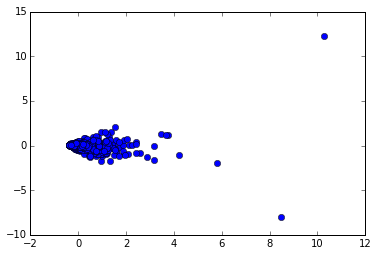

In [111]:
plt.plot(reduced_lower_thresholded_inverse_data[:,0], reduced_lower_thresholded_inverse_data[:,1], 'bo')

In [96]:
lower_thresholded_inverse_kmeans = cluster.KMeans(init='k-means++', n_clusters=10, n_init=10)
lower_thresholded_inverse_kmeans.fit(reduced_lower_thresholded_inverse_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [95]:
reduced_lower_thresholded_inverse_labels = list(lower_thresholded_inverse_kmeans.labels_)

#hist_kmeans_labels(reduced_lower_thresholded_inverse_labels, 'reduced_lower_thresholded_inverse_labels')
#visualize_kmeans(reduced_lower_thresholded_inverse_data, lower_thresholded_inverse_kmeans, 'lower_thresholded_inverse_kmeans')

Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 16, 23, 25, 47, 48, 73, 95, 129, 141]
Avg: 15.8684210526
Std dev: 35.2682733917


ValueError: zero-size array to reduction operation minimum which has no identity

#### Kmeans using truncated SVD on original signed sparse matrix.

In [130]:
# TODO

## Manifold Comparision

In [5]:
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    plt.plot(X[:,0], X[:,1], 'go')
    if title is not None:
        plt.title(title)

In [ ]:
if not SKIP_LONG_PARTS:
    X = dense_data
    n_samples, n_features = X.shape
    n_neighbors = 30

    #----------------------------------------------------------------------
    # Random 2D projection using a random unitary matrix
    print("Computing random projection")
    rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
    X_projected = rp.fit_transform(X)
    plot_embedding(X_projected, "Random Projection of the digits")


    #----------------------------------------------------------------------
    # Projection on to the first 2 principal components

    print("Computing PCA projection")
    t0 = time()
    X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
    plot_embedding(X_pca,
                   "Principal Components projection of the digits (time %.2fs)" %
                   (time() - t0))

    # We do not have y values.
    """
    #----------------------------------------------------------------------
    # Projection on to the first 2 linear discriminant components

    print("Computing LDA projection")
    X2 = X.copy()
    X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
    t0 = time()
    X_lda = lda.LDA(n_components=2).fit_transform(X2, y)
    plot_embedding(X_lda,
                   "Linear Discriminant projection of the digits (time %.2fs)" %
                   (time() - t0))
    """


    # Takes too long..
    """
    #----------------------------------------------------------------------
    # Isomap projection of the digits dataset
    print("Computing Isomap embedding")
    t0 = time()
    X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
    print("Done.")
    plot_embedding(X_iso,
                   "Isomap projection of the digits (time %.2fs)" %
                   (time() - t0))
    """


    #----------------------------------------------------------------------
    # Locally linear embedding of the digits dataset
    print("Computing LLE embedding")
    clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                          method='standard')
    t0 = time()
    X_lle = clf.fit_transform(X)
    print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
    plot_embedding(X_lle,
                   "Locally Linear Embedding of the digits (time %.2fs)" %
                   (time() - t0))


    #----------------------------------------------------------------------
    # Modified Locally linear embedding of the digits dataset
    print("Computing modified LLE embedding")
    clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                          method='modified')
    t0 = time()
    X_mlle = clf.fit_transform(X)
    print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
    plot_embedding(X_mlle,
                   "Modified Locally Linear Embedding of the digits (time %.2fs)" %
                   (time() - t0))


    #----------------------------------------------------------------------
    # HLLE embedding of the digits dataset
    print("Computing Hessian LLE embedding")
    clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                          method='hessian')
    t0 = time()
    X_hlle = clf.fit_transform(X)
    print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
    plot_embedding(X_hlle,
                   "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
                   (time() - t0))


    #----------------------------------------------------------------------
    # LTSA embedding of the digits dataset
    print("Computing LTSA embedding")
    clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                          method='ltsa')
    t0 = time()
    X_ltsa = clf.fit_transform(X)
    print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
    plot_embedding(X_ltsa,
                   "Local Tangent Space Alignment of the digits (time %.2fs)" %
                   (time() - t0))

    #----------------------------------------------------------------------
    # MDS  embedding of the digits dataset
    print("Computing MDS embedding")
    clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
    t0 = time()
    X_mds = clf.fit_transform(X)
    print("Done. Stress: %f" % clf.stress_)
    plot_embedding(X_mds,
                   "MDS embedding of the digits (time %.2fs)" %
                   (time() - t0))

    #----------------------------------------------------------------------
    # Random Trees embedding of the digits dataset
    print("Computing Totally Random Trees embedding")
    hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                           max_depth=5)
    t0 = time()
    X_transformed = hasher.fit_transform(X)
    pca = decomposition.TruncatedSVD(n_components=2)
    X_reduced = pca.fit_transform(X_transformed)

    plot_embedding(X_reduced,
                   "Random forest embedding of the digits (time %.2fs)" %
                   (time() - t0))

    #----------------------------------------------------------------------
    # Spectral embedding of the digits dataset
    print("Computing Spectral embedding")
    embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                          eigen_solver="arpack")
    t0 = time()
    X_se = embedder.fit_transform(X)

    plot_embedding(X_se,
                   "Spectral embedding of the digits (time %.2fs)" %
                   (time() - t0))

    """
    #----------------------------------------------------------------------
    # t-SNE embedding of the digits dataset
    print("Computing t-SNE embedding")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    t0 = time()
    X_tsne = tsne.fit_transform(X)

    plot_embedding(X_tsne,
                   "t-SNE embedding of the digits (time %.2fs)" %
                   (time() - t0))
    """

Computing random projection
Computing PCA projection
Computing LLE embedding

### PMI

In [6]:
inverted_index_keys = [k for k in inverted_index.keys() if len(inverted_index[k]) > 1]
num_inverted_index_keys = len(inverted_index_keys)
for i in range(num_inverted_index_keys):
    for j in range(i+1, num_inverted_index_keys):
        pmi = len(inverted_index[i].intersection(inverted_index[j]))
        
        if pmi == 0:
            continue
        
        pmi *= 1.0
        
        try:
            pmi /= len(inverted_index[i]) * len(inverted_index[j])
        except:
            continue
        pmi = np.log2(pmi)
        if pmi > 0.5:
            print i, j, pmi

KeyboardInterrupt: 

In [15]:
s = set()
s.add(1)
s.add(1)
s.add(2)

s1 = set()
s1.add(2)

print s.intersection(s1)
print s

set([2])
set([1, 2])


## Tests with Speech Graph

To start you off, you are told that points (rows, where the first row is number 0) 

2, 13, 18, 24 are examples of speeches that belong to category “Against" (=label 0) and speeches 

1, 3, 27, 177 are examples of speeches that belong to the “For”(=label 1) category

In [11]:
print np.where(speech_graph[2])

(array([   6,   10,   11,   15,   24,   27,   34,   36,   38,   42,   43,
         45,   46,   47,   51,   67,   68,   70,   90,   93,   95,  102,
        117,  120,  128,  134,  142,  143,  145,  148,  152,  154,  160,
        161,  162,  164,  168,  175,  176,  179,  185,  194,  201,  204,
        206,  209,  210,  212,  216,  217,  219,  224,  233,  241,  249,
        255,  258,  259,  260,  261,  262,  263,  265,  268,  272,  273,
        274,  279,  280,  297,  303,  309,  312,  313,  315,  324,  331,
        334,  335,  352,  353,  355,  359,  360,  364,  365,  366,  369,
        375,  383,  384,  393,  403,  406,  412,  414,  415,  416,  418,
        423,  424,  427,  433,  434,  435,  438,  442,  443,  444,  445,
        446,  447,  454,  455,  460,  461,  462,  468,  469,  472,  480,
        483,  487,  490,  492,  497,  500,  502,  523,  529,  532,  537,
        541,  546,  551,  557,  559,  563,  578,  589,  591,  592,  603,
        613,  617,  620,  627,  628,  634,  639,  

### Using both data structures

In [12]:
print 2276 in sparse_where(sparse_data, 1673)

False


In [66]:
def cluster_using_counters(counters, thresholds):
    cluster_tracker = {}
    clusters = []
    for counter, threshold in zip(counters, thresholds):
        for key in counter:
            if counter[key] < threshold:
                continue
            t = json.loads(key)

            row1 = t[0]
            other_rows = t[1:]

            for row2 in other_rows:
                if not row1 in cluster_tracker and not row2 in cluster_tracker:
                    cluster_tracker[row1] = len(clusters)
                    cluster_tracker[row2] = len(clusters)
                    clusters.append( [row1, row2] )
                # row1 is not labeled
                elif not row1 in cluster_tracker:
                    row2_index = cluster_tracker[row2]
                    clusters[row2_index].append(row1)
                    cluster_tracker[row1] = row2_index
                # row2 is not labeled
                elif not row2 in cluster_tracker:
                    row1_index = cluster_tracker[row1]
                    clusters[row1_index].append(row2)
                    cluster_tracker[row2] = row1_index
                # Both are already labeled, but in different clustesr.
                elif cluster_tracker[row1] != cluster_tracker[row2]:
                    row1_index = cluster_tracker[row1]
                    old_row2_index = cluster_tracker[row2]
                    # Merge row2's cluster into row1's cluster.
                    row2_cluster = clusters[old_row2_index]
                    clusters[row1_index].extend(row2_cluster)
                    clusters.pop(old_row2_index)

                    # Update indices > row2
                    for index in cluster_tracker:
                        if cluster_tracker[index] > old_row2_index:
                            cluster_tracker[index] -= 1
                    # Update row2's cluster indices.
                    row1_index = cluster_tracker[row1]
                    for index in row2_cluster:
                        cluster_tracker[index] = row1_index
    return clusters

[4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2]
408


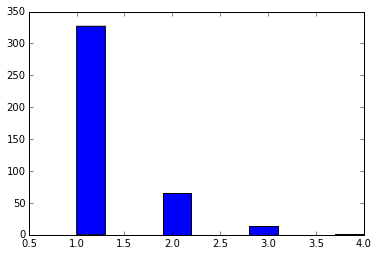

In [101]:
def create_counter(n_docs):
    docs_counter = collections.defaultdict(int)

    for k in inverted_index:
        v = inverted_index[k]
        if len(v) == n_docs:
            docs_counter[str(sorted(v))] += 1
    return docs_counter

counter_2 = create_counter(13)
counter_2_values = counter_2.values()
plt.hist(counter_2_values)
counter_2_values.sort(reverse=True)
print counter_2_values[:20]
print len(counter_2_values)

In [102]:
counters = [create_counter(n) for n in [2,5,11, 13]]
thresholds = [10,9,3, 4]

In [121]:
clusters = cluster_using_counters(counters, thresholds)
print '==='
print [len(c) for c in clusters]
for c in clusters:
    print c

===
[2, 2, 2, 5, 11, 323]
[269, 1962]
[6, 2594]
[1164, 2483]
[19, 272, 957, 1704, 2405]
[506, 602, 716, 761, 981, 1091, 1477, 1871, 2234, 2601, 2662]
[59, 355, 22, 82, 88, 238, 379, 657, 659, 861, 102, 275, 426, 249, 346, 817, 843, 449, 471, 630, 632, 1049, 1276, 1515, 262, 274, 564, 228, 270, 276, 609, 24, 211, 237, 271, 79, 477, 258, 265, 1059, 1426, 131, 551, 776, 899, 951, 229, 464, 496, 668, 747, 1374, 1612, 1624, 1674, 1911, 1945, 497, 577, 452, 573, 591, 508, 638, 679, 1115, 1172, 233, 736, 748, 955, 1063, 1200, 20, 145, 539, 544, 1011, 1194, 1645, 1661, 1765, 197, 1377, 1416, 1455, 1474, 1637, 2276, 1916, 2198, 2317, 2319, 2428, 2707, 1773, 2262, 2360, 2449, 8, 213, 492, 778, 881, 1277, 1392, 1417, 1419, 2327, 2559, 2684, 846, 1105, 1112, 1240, 1270, 1549, 1753, 2027, 2217, 278, 603, 804, 1121, 1563, 1615, 1656, 383, 610, 674, 796, 1150, 1396, 1759, 1831, 1877, 2012, 2158, 2375, 1523, 1567, 2057, 2357, 634, 1025, 1875, 2025, 2185, 1182, 1442, 1634, 2366, 2517, 2528, 2556, 2541,

In [125]:
def trim_clusters(clusters):
    trimmed_clusters = []
    for cluster in clusters:
        max_votes = len(cluster)
        new_cluster = []
        counter = collections.defaultdict(int)
        for c1 in cluster:
            for c2 in cluster:
                if c2 in sparse_where(speech_graph, c1):
                    counter[c2] += 1
        for k in counter:
            if counter[k] > 0.5 * max_votes:
                new_cluster.append(k)
        trimmed_clusters.append(new_cluster)
    return trimmed_clusters

In [126]:
trimmed_clusters = trim_clusters(clusters)

In [128]:
print '==='
print [len(c) for c in trimmed_clusters]
for c in trimmed_clusters:
    print c

===
[0, 0, 0, 3, 0, 0]
[]
[]
[]
[19, 957, 2405]
[]
[]


In [131]:
row1 = 0
counter = 0
for row2 in sparse_where(speech_graph, row1):
    if row1 in sparse_where(speech_graph, row2):
        counter += 1
        
print counter, len(sparse_where(speech_graph, row1))

562 562


(array([  23.,  241.,  581.,  541.,  353.,   97.,  164.,  437.,  259.,   44.]),
 array([ 457. ,  488.6,  520.2,  551.8,  583.4,  615. ,  646.6,  678.2,
         709.8,  741.4,  773. ]),
 <a list of 10 Patch objects>)

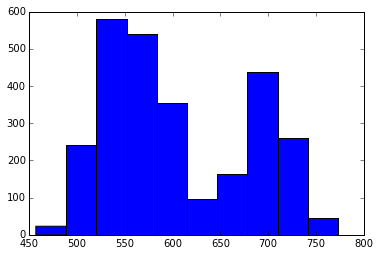

In [132]:
plt.hist( [len(sparse_where(speech_graph,i)) for i in range(NUM_SPEECHES)] )

In [137]:
print 'Against'
print [len(sparse_where(speech_graph, i)) for i in LABELS_AGAINST]
print 'For'
print [len(sparse_where(speech_graph, i)) for i in LABELS_FOR]

Against
[589, 553, 610, 752]
For
[518, 693, 632, 580]


0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %


(array([  26.,  371.,  681.,  524.,  211.,   23.,  169.,  436.,  255.,   44.]),
 array([ 275052. ,  296823.3,  318594.6,  340365.9,  362137.2,  383908.5,
         405679.8,  427451.1,  449222.4,  470993.7,  492765. ]),
 <a list of 10 Patch objects>)

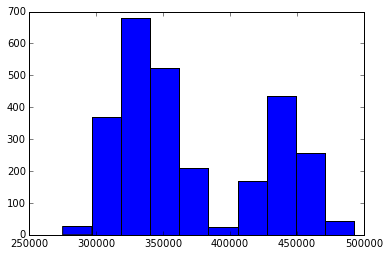

In [143]:
counts_of_one = [0 for i in range(NUM_SPEECHES)]
for i in range(NUM_SPEECHES):
    row_i = sparse_where(speech_graph,i)
    counts_of_one[i] += len(row_i)
    for e in row_i:
        counts_of_one[i] += len(sparse_where(speech_graph,e))
        
    if i % 150 == 0:
        print 100.0 * i / NUM_SPEECHES, '%'
print 100.0 * i / NUM_SPEECHES, '%'
plt.hist(counts_of_one)

In [145]:
print 'Against'
print sorted([counts_of_one[i] for i in LABELS_AGAINST])
print 'For'
print sorted([counts_of_one[i]  for i in LABELS_FOR])

Against
[332641, 355057, 370482, 478225]
For
[314930, 352561, 382767, 437641]


(array([   1.,    0.,    9.,   14.,   24.,   61.,   87.,  123.,  127.,
         191.,  152.,  151.,  162.,  127.,  127.,  137.,  103.,   86.,
          57.,   40.,   27.,   17.,   17.,   17.,   33.,   71.,   80.,
         111.,  132.,  114.,  105.,   93.,   54.,   41.,   25.,   13.,
           3.,    8.]),
 array([ 457.        ,  465.31578947,  473.63157895,  481.94736842,
         490.26315789,  498.57894737,  506.89473684,  515.21052632,
         523.52631579,  531.84210526,  540.15789474,  548.47368421,
         556.78947368,  565.10526316,  573.42105263,  581.73684211,
         590.05263158,  598.36842105,  606.68421053,  615.        ,
         623.31578947,  631.63157895,  639.94736842,  648.26315789,
         656.57894737,  664.89473684,  673.21052632,  681.52631579,
         689.84210526,  698.15789474,  706.47368421,  714.78947368,
         723.10526316,  731.42105263,  739.73684211,  748.05263158,
         756.36842105,  764.68421053,  773.        ]),
 <a list of 38 Patch obje

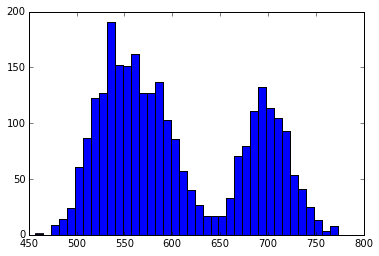

In [158]:
inverted_graph_values = [len(v) for v in inverted_graph.values()]
plt.hist(inverted_graph_values, bins=38)

In [157]:
inverted_graph_values.sort()
print inverted_graph_values[:20]
print inverted_graph_values[-20:]

[457, 474, 474, 478, 479, 480, 481, 481, 481, 481, 482, 483, 483, 483, 484, 486, 486, 486, 487, 487]
[752, 752, 752, 753, 753, 754, 755, 756, 756, 757, 758, 764, 765, 766, 766, 767, 768, 770, 772, 773]


## Looking for Distribution Mismatches

In [19]:
std_devs = []
for i in range(NUM_SPEECHES):
    std_devs.append(np.std( [len(sparse_where(speech_graph,j)) for j in sparse_where(speech_graph,i)] ))
    
    if i % 150 == 0:
        print 100.0 * i / NUM_SPEECHES, '%'
print 100.0 * i / NUM_SPEECHES, '%'

0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %


(array([  43.,  189.,  344.,  377.,  692.,  650.,  116.,   31.,  203.,   95.]),
 array([ 65.20623219,  66.96296498,  68.71969777,  70.47643055,
         72.23316334,  73.98989613,  75.74662891,  77.5033617 ,
         79.26009449,  81.01682727,  82.77356006]),
 <a list of 10 Patch objects>)

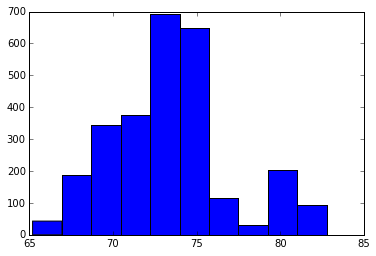

In [20]:
plt.hist(std_devs)

### Load diffs

In [185]:
diffs = json.load(open('diffs.json'))
assert len(diffs) == 1656376
assert np.isclose(np.std(diffs), 96.5386873527)
assert np.isclose(np.average(diffs), 0.0)

### Recalculate diffs

In [22]:
diffs = []
for i in range(NUM_SPEECHES):
    a = len(sparse_where(speech_graph,i))
    diffs.extend( [a-len(sparse_where(speech_graph,j)) for j in sparse_where(speech_graph,i)] )
    
    if i % 150 == 0:
        print 100.0 * i / NUM_SPEECHES, '%'
print 100.0 * i / NUM_SPEECHES, '%'

0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %


# of diffs 1656376
# zeros 0.630050181843 %
---
0.0 96.5386873527
% in one std dev 66.4737958048 %
% in two std dev 95.8982743049 %
# out one std dev 555320.0
# out two std dev 67940.0


(array([  1.18000000e+02,   1.88300000e+03,   1.27170000e+04,
          4.24100000e+04,   7.66760000e+04,   8.37510000e+04,
          7.48050000e+04,   8.81550000e+04,   1.64187000e+05,
          2.78268000e+05,   2.88704000e+05,   1.64187000e+05,
          8.81550000e+04,   7.48050000e+04,   8.37510000e+04,
          7.66760000e+04,   4.24100000e+04,   1.27170000e+04,
          1.88300000e+03,   1.18000000e+02]),
 array([-301. , -270.9, -240.8, -210.7, -180.6, -150.5, -120.4,  -90.3,
         -60.2,  -30.1,    0. ,   30.1,   60.2,   90.3,  120.4,  150.5,
         180.6,  210.7,  240.8,  270.9,  301. ]),
 <a list of 20 Patch objects>)

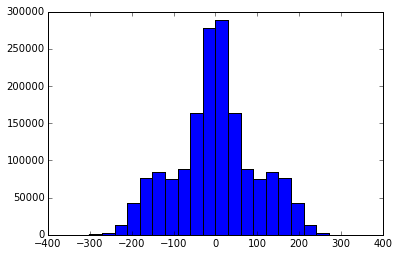

In [201]:
diff_len = len(diffs)
print '# of diffs', diff_len
print '# zeros', 100.0 * diffs.count(0) / diff_len , '%'
diff_avg = np.average(diffs)
diff_std_dev = np.std(diffs)
print '---'
print diff_avg, diff_std_dev
percent_one_dev = 100.0 * sum([1 for i in diffs if diff_avg + diff_std_dev > i > diff_avg - diff_std_dev]) / diff_len
percent_two_dev =  100.0 * sum([1 for i in diffs if diff_avg + 2*diff_std_dev > i > diff_avg - 2*diff_std_dev]) / diff_len
print '% in one std dev', percent_one_dev, '%'
print '% in two std dev', percent_two_dev, '%'
print '# out one std dev', diff_len * (100.0 - percent_one_dev) / 100.0
print '# out two std dev', diff_len * (100.0 - percent_two_dev) / 100.0
plt.hist(diffs, bins=20)

In [94]:
diffs.sort()
json.dump(diffs, open('diffs.json', 'w+'))

### Propagation using differences in row lengths

#### Notes:

propagate_labels using 2 std dev: Accuracy 0.59161
 - preds_propagation1.csv
 - Num predictions: 2339
 - [855, 586, 898] num against, num zero, num for (from propagation)
 - Num yes: 1885 (after accounting for unresolved speeches) (68.795620438%)
 
propagate_labels using 1 std dev: Accuracy 0.55438
 - preds_propagation2.csv
 - using bugfixed code
 - Num predictions: 2740
 - Num yes: 1777 ( 64.8540145985 % )
 - [963, 0, 1777]
   
    propagate_labels2(LABELS_FOR)
    
    propagate_labels2(LABELS_AGAINST)
    
    next_propagation_keys = set(predicted_labels.keys()).difference(ORIG_LABELS)
    
    propagate_labels2(next_propagation_keys)

In [181]:
print 100.0 * 1885 / NUM_SPEECHES

68.795620438


In [195]:
# < 0 = against
# > 0 = for

predicted_labels = collections.defaultdict(int)

speech_row_sums = {i: len(sparse_where(speech_graph, i)) for i in range(NUM_SPEECHES)}

for label in LABELS_AGAINST:
    predicted_labels[label] = -1
for label in LABELS_FOR:
    predicted_labels[label] = 1
    
# bounds for std deviation
upper_bound = diff_avg + 1 * diff_std_dev
lower_bound = diff_avg - 1 * diff_std_dev
print upper_bound, lower_bound

def propagate_labels2(labels):
    
    new_parent_dict = collections.defaultdict(set)
    newly_labeled = set()
    
    for curr_label in labels:
        curr_len = speech_row_sums[curr_label]
        curr_indices = sparse_where(speech_graph, curr_label)
        for reference in curr_indices:
         
            # Do not reassign the original labels.
            if reference in ORIG_LABELS or reference in predicted_labels:
                continue
                
            sum_diff = curr_len - speech_row_sums[reference]

            #if upper_bound > sum_diff > lower_bound: #Used for current first place. This is a bug!
            if sum_diff > upper_bound or lower_bound > sum_diff:
                predicted_labels[reference] += np.sign(predicted_labels[curr_label])
                newly_labeled.add(reference)
                new_parent_dict[reference].add(curr_label)

def propagate_labels(labels, parent_labels_dict, parent_labels):
    
    new_parent_dict = collections.defaultdict(set)
    newly_labeled = set()
    
    for curr_label in labels:
        curr_len = speech_row_sums[curr_label]
        curr_indices = sparse_where(speech_graph, curr_label)
        for reference in curr_indices:
            
            # Only propagate labels forward.
            
            if reference in parent_labels_dict[curr_label] and reference not in ORIG_LABELS:
                continue
                
            # We can influence a parent that was not our parent.
            if reference in parent_labels and reference not in ORIG_LABELS:
                predicted_labels[reference] += np.sign(predicted_labels[curr_label])
                # Do NOT add to newly_labeled
                continue
            
            # Do not reassign the original labels.
            if reference in ORIG_LABELS:
                continue
                
            sum_diff = curr_len - speech_row_sums[reference]

            #if upper_bound > sum_diff > lower_bound: #Used for current first place. This is a bug!
            if sum_diff > upper_bound or lower_bound > sum_diff:
                predicted_labels[reference] += np.sign(predicted_labels[curr_label])
                newly_labeled.add(reference)
                new_parent_dict[reference].add(curr_label)
                
    return newly_labeled, new_parent_dict
                
def run_propagation(labels, num_iters):
    newly_labeled, new_parent_dict = propagate_labels(LABELS_FOR, collections.defaultdict(set), set())
    prev_labels = labels
    for i in range(num_iters):
        prev_labels_temp = newly_labeled
        newly_labeled, new_parent_dict = propagate_labels(newly_labeled, new_parent_dict, prev_labels)
        prev_labels = prev_labels_temp

NUM_ITERS = 0

# Best score so far
#propagate_labels(LABELS_FOR, collections.defaultdict(set), set())
#propagate_labels(LABELS_AGAINST, collections.defaultdict(set), set())

# without using run_propagation
propagate_labels2(LABELS_FOR)
propagate_labels2(LABELS_AGAINST)
next_propagation_keys = set(predicted_labels.keys()).difference(ORIG_LABELS)
propagate_labels2(next_propagation_keys)

#run_propagation(LABELS_FOR, 0)
#run_propagation(LABELS_AGAINST, 0)

print 'Done'

96.5386873527 -96.5386873527
Done


In [187]:
for k in sorted(predicted_labels.keys()):
    print k,predicted_labels[k]

0 -1
1 1
2 -1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 -1
14 -1
15 1
16 -1
17 -1
18 -1
19 1
20 1
21 1
22 1
23 1
24 -1
25 -1
26 1
27 1
28 -1
29 1
30 -1
31 1
32 1
33 1
34 1
35 1
36 1
37 -1
38 -1
39 1
40 -1
41 -1
42 1
43 -1
44 1
45 1
46 1
47 1
48 -1
49 1
50 -1
51 -1
52 1
53 1
54 -1
55 -1
56 -1
57 1
58 1
59 -1
60 1
61 1
62 1
63 -1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 -1
76 -1
77 1
78 1
79 1
80 1
81 1
82 -1
83 -1
84 1
85 1
86 1
87 -1
88 1
89 1
90 1
91 -1
92 1
93 1
94 1
95 -1
96 -1
97 1
98 -1
99 1
100 1
101 -1
102 -1
103 1
104 -1
105 1
106 1
107 1
108 1
109 -1
110 1
111 1
112 -1
113 1
114 1
115 -1
116 1
117 -1
118 1
119 -1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 -1
128 1
129 -1
130 1
131 1
132 -1
133 1
134 -1
135 1
136 -1
137 1
138 1
139 1
140 1
141 -1
142 1
143 1
144 1
145 1
146 -1
147 -1
148 1
149 -1
150 1
151 -1
152 -1
153 1
154 1
155 -1
156 1
157 -1
158 1
159 -1
160 1
161 1
162 -1
163 -1
164 -1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 -1
173 -1
174 1


In [196]:
print 'Num predictions:', len(predicted_labels)
print '==='
yes = 0
predicted_tuples = []
for k in range(NUM_SPEECHES):
    if k in predicted_labels and predicted_labels[k] != 0:
        if predicted_labels[k] > 0:
            yes += 1
            #print str(k) + ',1'
            predicted_tuples.append( (k,1) )
        else:
            #print str(k) + ',0'
            predicted_tuples.append( (k,0) )
    else:
        yes += 1
        #print str(k) + ',1' # Assign for by default
        predicted_tuples.append( (k,1) )

write_evaluation(predicted_tuples, 'preds_propagation3.csv')
        
print 'Num yes:', yes, '(', 100.0 * yes / NUM_SPEECHES ,'% )'

Num predictions: 2740
===
Num yes: 1777 ( 64.8540145985 % )


In [194]:
# num against, num zero, num for
num_pred_categories = [0, 0, 0]
for k in predicted_labels:
    num_pred_categories[np.sign(predicted_labels[k])+1] += 1
    
print num_pred_categories
print '% against', 1.0 * num_pred_categories[0] / len(predicted_labels)
print '% zero', 1.0 * num_pred_categories[1] / len(predicted_labels)
print '% for', 1.0 * num_pred_categories[2] / len(predicted_labels)

[963, 0, 1777]
% against 0.351459854015
% zero 0.0
% for 0.648540145985


In [93]:
print min(diffs) + diff_avg
print max(diffs) - diff_avg

-301.0
301.0


## Spectral Clustering on the Speech Graph

Attempt to modify input adjacency matrix to remove links to docs in the same cluster.

In [48]:
# Find the minimum row sum.

speech_row_sums = {i: len(sparse_where(speech_graph, i)) for i in range(NUM_SPEECHES)}

min_key = -1
min_val = 1000
for k in speech_row_sums:
    if speech_row_sums[k] < min_val:
        min_key = k
        min_val = speech_row_sums[k]
        
print min_key, min_val

min_keys_refs_sums = []
for i in sparse_where(speech_graph, i):
    min_keys_refs_sums.append(speech_row_sums[i])
    
plt.hist(min_keys_refs_sums, bins=40)

TypeError: list indices must be integers, not tuple

In [49]:
def spectral_clustering(A, us, title):
    """
    Arguments:
        A: An adjacency matrix.
    Returns:
        A 0-1 vector deliminating the clusters, in the same order as the row
        in the input.
    """
    n = A.shape[0]

    L = np.eye(n)

    D = np.zeros(A.shape)
    for i in  range(n):
        D[i,i] = 1/np.sqrt(np.sum(A[i,:]))

    L -= np.dot(np.dot(D,A), D)

    eig_vals, eig_vecs = np.linalg.eig(L)
    n_eigs = len(eig_vals)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(n_eigs)]
    eig_pairs.sort(key=lambda t:t[0])

    ps =[ [x,y] for x,y in zip(eig_pairs[0][1], eig_pairs[1][1]) ]
    return ps
    
    #c, u_f = k_means(ps, us)
    
    #plot(ps, c, us=us, title='Embeddings for ' + title)

    #return c, u_f

Notes:

We will assume the data has no noise, in the hopes that this will not drastically affect the spectral clustering.

Assuming for/against are split 50/50, then 2740 * 0.5 = 1370:

Assume 30% chance of linking to another speech with the same label.
( Note that 457 - (1370 * 0.3) = 46, which leaves just enough room for noise. 457 is the smallest row sum. )

Assuming binomial distribution with p = 30%:

Standard dev of added links = np.sqrt( (1370) * .3 * .7 ) = 16.9617216107

Since number of trials = 1370, we can approximation the distribution by a normal.

Thus 95% percent of the speechs will have +/- 33.9234432215 extra links and 99.7% of the speechs will have +/- 50.8851648322 extra links.

We assumed that when.

Condition:

if abs(speech_row_sums[index] - speech_row_sums[row]) <= ceiling, then speech_graph_copy[row, index] = 0.0
    - ceiling =14.4808031029 yields 10.802919708% minority class
        - shape of 2d project is three clusters

    - ceiling = 24.1346718382 yields 47.7372262774% minority class
       - shape of 2d projection is two slowly merging clusters
       
    - ceiling = 45.3731830558, yields 47.6642335766%
       - two separated clusters
 
    - ceiling = 50.8851648322 yields 47.700729927% minority
        - two separated clusters
    
    -  ceiling = 48.2693436763 yields 47.6277372263% minority class 
       - shape of 2d projection is two almost separated clusters (looks best so far)

    - ceiling = 53.096278044 yields 47.5912408759% minority class
      - two barely separated clusters

    - ceiling = 96.5386873527 yields 35.9489051095% minority class 
       - shape of 2d projection is an upside down Y

In [283]:
print 457 - (1370 * 0.3)

p = 0.30
print 'std dev', np.sqrt( (1370) * p * (1-p) ) 
print '2 std devs', 2 * np.sqrt( (1370) * p * (1-p) ) 
print '3 std devs',  3 * np.sqrt( (1370) * p * (1-p) ) 

46.0
std dev 16.9617216107
2 std devs 33.9234432215
3 std devs 50.8851648322


In [92]:
speech_graph_copy = load_sparse_data('speech_graph.csv', NUM_SPEECHES)

Reading data.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %
Done reading data.


In [304]:
#
# Bad ass motherfucking code starts right here.
#

speech_graph_copy, _ = load_sparse_data('speech_graph.csv', NUM_SPEECHES)

speech_row_sums = {i: len(sparse_where(speech_graph, i)) for i in range(NUM_SPEECHES)}

# Create affinity matrix.
print 'Creating affinity matrix.'
for row in range(NUM_SPEECHES):
    row_indices = sparse_where(speech_graph, row)
    for index in row_indices:
        if abs(speech_row_sums[index] - speech_row_sums[row]) <= 50.8851648322 :
            speech_graph_copy[row, index] = 0.0
    if row % 150 == 0:
        print row * 100.0 / NUM_SPEECHES, '%'

print 'Done'

Reading data.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
99.9635036496 %
Done reading data.
Creating affinity matrix.
0.0 %
5.47445255474 %
10.9489051095 %
16.4233576642 %
21.897810219 %
27.3722627737 %
32.8467153285 %
38.3211678832 %
43.795620438 %
49.2700729927 %
54.7445255474 %
60.2189781022 %
65.6934306569 %
71.1678832117 %
76.6423357664 %
82.1167883212 %
87.5912408759 %
93.0656934307 %
98.5401459854 %
Done


### Their Laplacian

Calculating spectral clustering.
47.700729927
labels against
1 1 1 1
lablels for
0 0 0 0


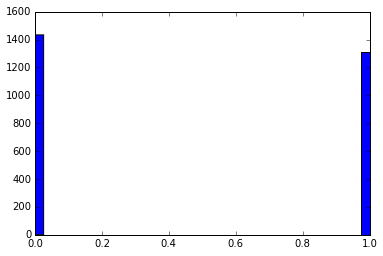

In [298]:
print 'Calculating spectral clustering.'
spectral_labels = cluster.spectral_clustering(speech_graph_copy, n_clusters=2)
plt.hist(spectral_labels, bins=38)

print ''

print 'Minority percentage'
print 100.0 * min(sum(spectral_labels), NUM_SPEECHES-sum(spectral_labels)) / NUM_SPEECHES

print ''

print 'labels for original against', spectral_labels[2], spectral_labels[13], spectral_labels[18], spectral_labels[24]
print 'labels for original for' spectral_labels[1], spectral_labels[3], spectral_labels[27], spectral_labels[177]

In [303]:
preds_laplacian_tuples = []
for i in range(NUM_SPEECHES):
    #
    # Important! Make sure the original points are in the right cluster because labeling is arbitrary!!
    #
    preds_laplacian_tuples.append( (i, abs(spectral_labels[i]-1)) )
write_evaluation(preds_laplacian_tuples, 'preds_laplacian.csv')

### My Laplacian (2D + plot)

In [294]:
n_dims = 4
points = spectral_clustering(speech_graph_copy.toarray(), None, n_dims)

print len(points)

x_against = [points[2][0], points[13][0], points[18][0], points[24][0]]
y_against = [points[2][1], points[13][1], points[18][1], points[24][1]]

x_for = [points[1][0], points[3][0], points[27][0], points[127][0]]
y_for = [points[1][1], points[3][1], points[27][1], points[127][1]]

2740


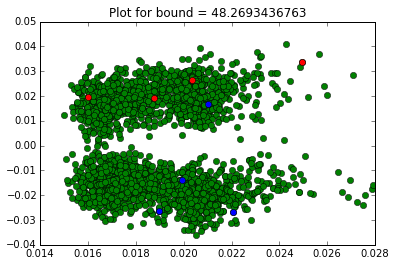

In [291]:
#
#  DO NOT REFRESH!
#

plt.plot([p[0] for p in points], [p[1] for p in points], 'go')
plt.plot(x_against, y_against, 'ro')
plt.plot(x_for, y_for, 'bo')
plt.title('Plot for bound = 48.2693436763')

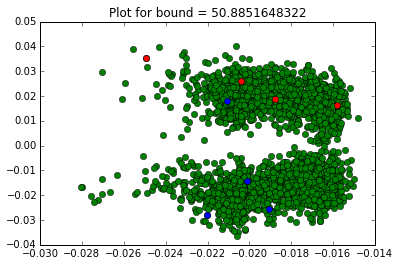

In [296]:
#
#  DO NOT REFRESH!
#

plt.plot([p[0] for p in points], [p[1] for p in points], 'go')
plt.plot(x_against, y_against, 'ro')
plt.plot(x_for, y_for, 'bo')
plt.title('Plot for bound = 50.8851648322')

In [217]:
print 100.0 * sum(1 for p in points if p[1] < -0.01) / NUM_SPEECHES

33.102189781


## Topic Modeling

In [11]:
# Clean the old models.

stopwords = set([str(w) for w in inverted_index if len(inverted_index[w]) > 329])

dirty_dir = 'generated_docs'
clean_dir = 'clean_docs'

if not os.path.exists(clean_dir):
    os.mkdir(clean_dir)

for f in os.listdir(dirty_dir):
    text = ' '.join(open(os.path.join(dirty_dir,f)).readlines())
    text = text.split()
    text = [t for t in text if t not in stopwords]
    text = ' '.join(text)
    open(os.path.join(clean_dir, f), 'w+').write(text)  

38
[30, 33, 34, 35, 36, 36, 36, 36, 37, 38, 39, 40, 45, 47, 47, 47, 49, 50, 58, 71, 74, 79, 82, 83, 84, 85, 86, 87, 93, 96, 107, 111, 112, 114, 116, 150, 160, 177]
[0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807, 0.0499939885807]


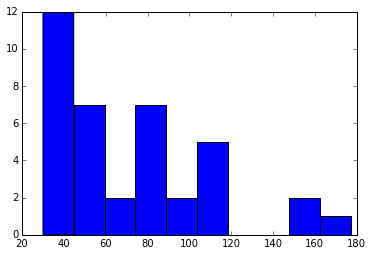

In [31]:
## Record the predicted classes (execute after running run_lda.py)

CLASS_FILE = 'classes_75k_50p_38t_329sw.txt'
OUTPUT = 'preds_' + CLASS_FILE 

probs = [-1 for i in range(2740)]
classes = [-1 for i in range(2740)]
class_inv_idx = collections.defaultdict(int)

for line in open(CLASS_FILE):
    parts = line.strip().split()
    doc_num = int(parts[0].split(os.path.sep)[-1].split('.')[0])

    for i in range(1, len(parts), 2):
        c = int(parts[i]) # probability
        p = float(parts[i+1]) # class
        if p > probs[doc_num]:
            classes[doc_num] = c
            probs[doc_num] = p

    class_inv_idx[classes[doc_num]] += 1
with open(OUTPUT, 'w+') as f:
    for doc_num, prediction in enumerate(classes):
        f.write(str(doc_num) + ',' + str(prediction) + '\n')

print len(set(classes))
plt.hist(class_inv_idx.values())
print sorted(class_inv_idx.values())
print sorted(probs)[:25]